In [3]:

import matplotlib.pyplot as plt
import imutils
import numpy as np
import pandas as pd
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"
from glob import glob
import spacy
import re
import string

In [4]:
img_orig = cv2.imread('./images/03.jpg')

In [5]:
cv2.namedWindow('original',cv2.WINDOW_NORMAL)
cv2.imshow('original',img_orig)
cv2.waitKey()
cv2.destroyAllWindows()

### Scanning

#### 1. Resize the image and set aspect ratio

In [6]:
def resizer(image,width=500):
    # get widht and height
    h,w,c = image.shape
    
    height = int((h/w)* width )
    size = (width,height)
    image = cv2.resize(image,(width,height))
    return image, size

In [ ]:
'''img_re,size = resizer(img_orig)
print(size)
cv2.imshow('Resize',img_re)
cv2.waitKey()
cv2.destroyAllWindows()'''

(500, 666)


#### 2. Image Processing
1. Enhance
2. Grayscale
3. Blur
4. Edge Detect
5. Morphological transform
6. Countors
7. Find Four Points


In [12]:
detail = cv2.detailEnhance(img_re,sigma_s = 20, sigma_r = 0.15)
gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY) # GRAYSCALE IMAGE
blur = cv2.GaussianBlur(gray,(5,5),0)
# edge detect
edge_image = cv2.Canny(blur,75,200)
# morphological transform
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(edge_image,kernel,iterations=1)
closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)

# find the contours
contours , hire = cv2.findContours(closing,
                                   cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)
for contour in contours:
    peri = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,0.02*peri, True)
    
    if len(approx) == 4:
        four_points = np.squeeze(approx)
        break
        
cv2.drawContours(img_re,[four_points],-1,(0,255,0),3)

# find four points for original image
multiplier = img_orig.shape[1] / size[0]
four_points_orig = four_points * multiplier
four_points_orig = four_points_orig.astype(int)

In [13]:
from imutils.perspective import four_point_transform

In [14]:
wrap_image = four_point_transform(img_orig,four_points_orig)

In [15]:
'''cv2.imshow('wrap',wrap_image)
cv2.waitKey(0)
cv2.destroyAllWindows()'''

"cv2.imshow('wrap',wrap_image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()"

### document scanner function

In [16]:
def document_scanner(image):

    img_re,size = resizer(image)
    detail = cv2.detailEnhance(img_re,sigma_s = 20, sigma_r = 0.15)
    gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY) # GRAYSCALE IMAGE
    blur = cv2.GaussianBlur(gray,(5,5),0)
    # edge detect
    edge_image = cv2.Canny(blur,75,200)
    # morphological transform
    kernel = np.ones((5,5),np.uint8)
    dilate = cv2.dilate(edge_image,kernel,iterations=1)
    closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)

    # find the contours
    contours , hire = cv2.findContours(closing,
                                       cv2.RETR_LIST,
                                       cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        peri = cv2.arcLength(contour,True)
        approx = cv2.approxPolyDP(contour,0.02*peri, True)

        if len(approx) == 4:
            four_points = np.squeeze(approx)
            break

    cv2.drawContours(img_re,[four_points],-1,(0,255,0),3)

    # find four points for original image
    multiplier = image.shape[1] / size[0]
    four_points_orig = four_points * multiplier
    four_points_orig = four_points_orig.astype(int)

    wrap_image = four_point_transform(image,four_points_orig)
    
    return wrap_image, four_points_orig, img_re, closing

In [17]:
img = cv2.imread('./images/015.jpg')
wrpimg, points, cnt_img, edgeimg = document_scanner(img)

In [18]:
'''cv2.imshow('original',img)
cv2.imshow('resize',cnt_img)
cv2.imshow('edge',edgeimg)
cv2.imshow('wrap',wrpimg)
cv2.waitKey()
cv2.destroyAllWindows()'''

"cv2.imshow('original',img)\ncv2.imshow('resize',cnt_img)\ncv2.imshow('edge',edgeimg)\ncv2.imshow('wrap',wrpimg)\ncv2.waitKey()\ncv2.destroyAllWindows()"

### Magic Color

In [19]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [20]:
rgb = cv2.cvtColor(wrpimg,cv2.COLOR_BGR2RGB)
magic_image = apply_brightness_contrast(rgb,120,0)
magic_image_c1 = apply_brightness_contrast(rgb,0,40)
magic_image_c2 = apply_brightness_contrast(rgb,50,40)

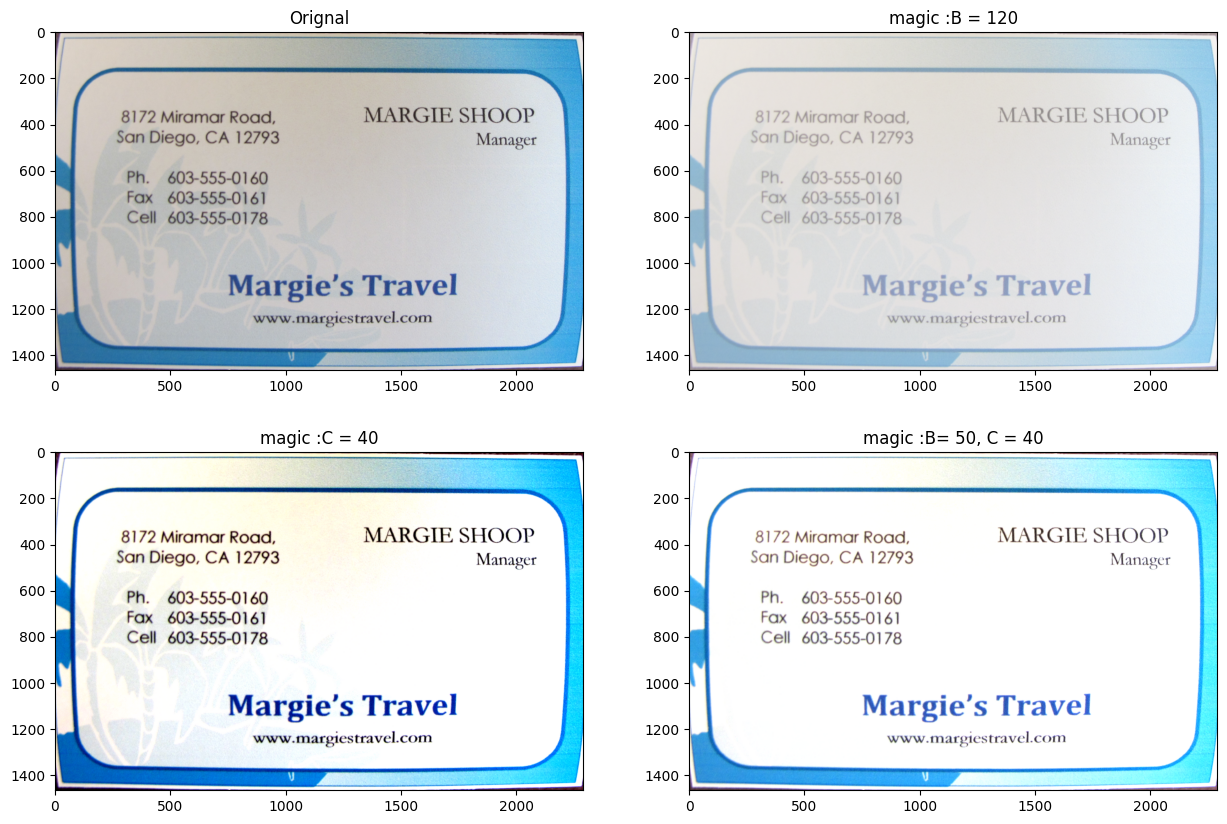

In [21]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(rgb)
plt.title('Orignal')

plt.subplot(2,2,2)
plt.imshow(magic_image)
plt.title('magic :B = 120')

plt.subplot(2,2,3)
plt.imshow(magic_image_c1)
plt.title('magic :C = 40')


plt.subplot(2,2,4)
plt.imshow(magic_image_c2)
plt.title('magic :B= 50, C = 40')

plt.show()

### Predictions

In [22]:
def cleanText(txt):
    whitespace = string.whitespace
    punctuation = "!#$%&\'()*+:;<=>?[\\]^`{|}~"
    tableWhitespace = str.maketrans('','',whitespace)
    tablePunctuation = str.maketrans('','',punctuation)
    text = str(txt)
    text = text.lower()
    removewhitespace = text.translate(tableWhitespace)
    removepunctuation = removewhitespace.translate(tablePunctuation)
    
    return str(removepunctuation)

model_ner = spacy.load('./output/model-best/')

tessData = pytesseract.image_to_data(magic_image_c2)
# convert into dataframe
tessList = list(map(lambda x:x.split('\t'), tessData.split('\n')))
df = pd.DataFrame(tessList[1:],columns=tessList[0])
df.dropna(inplace=True) # drop missing values
df['text'] = df['text'].apply(cleanText)

# convet data into content
df_clean = df.query('text != "" ')
content = " ".join([w for w in df_clean['text']])
print(content)
# get prediction from NER model
doc = model_ner(content)
docjson = doc.to_json()
doc_text = docjson['text']
datafram_tokens = pd.DataFrame(docjson['tokens'])
datafram_tokens = pd.DataFrame(docjson['tokens'])
datafram_tokens['token'] = datafram_tokens[['start','end']].apply(
    lambda x:doc_text[x[0]:x[1]] , axis = 1)

right_table = pd.DataFrame(docjson['ents'])[['start','label']]
datafram_tokens = pd.merge(datafram_tokens,right_table,how='left',on='start')
datafram_tokens.fillna('O',inplace=True)

# join lable to df_clean dataframe
df_clean['end'] = df_clean['text'].apply(lambda x: len(x)+1).cumsum() - 1 
df_clean['start'] = df_clean[['text','end']].apply(lambda x: x[1] - len(x[0]),axis=1)

# inner join with start 
dataframe_info = pd.merge(df_clean,datafram_tokens[['start','token','label']],how='inner',on='start')

bb_df = dataframe_info.query("label != 'O' ")
img = magic_image_c2.copy()

for x,y,w,h,label in bb_df[['left','top','width','height','label']].values:
    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)
    
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(img,str(label),(x,y),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2)



/Users/kyunghoon/Desktop/udemy_ocr/ocr3/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.1.3 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


8172 miramar road, margie shoop san diego, ca 12793 manager ph. 603-555-0160 fax 603-555-0161 cell 603-555-0178 margie’s travel www.marpiestravel.com


/var/folders/jn/5dk_wkhs7h1dx73g1b0tf58m0000gn/T/ipykernel_37858/1121941647.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x:doc_text[x[0]:x[1]] , axis = 1)
/var/folders/jn/5dk_wkhs7h1dx73g1b0tf58m0000gn/T/ipykernel_37858/1121941647.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['end'] = df_clean['text'].apply(lambda x: len(x)+1).cumsum() - 1
/var/folders/jn/5dk_wkhs7h1dx73g1b0tf58m0000gn/T/ipykernel_37858/1121941647.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wi

In [23]:
cv2.imshow('Predictions',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [25]:
bb_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,end,start,token,label
9,5,1,1,1,2,5,1825,441,260,72,96.495605,manager,59,52,manager,B-DES
11,5,1,2,1,1,2,489,606,433,59,94.095276,603-555-0160,76,64,603,B-PHONE
15,5,1,2,1,3,2,489,779,433,59,96.152122,603-555-0178,111,99,603,B-PHONE
18,5,1,4,1,1,1,858,1211,774,70,32.206459,www.marpiestravel.com,149,128,www.marpiestravel.com,B-WEB
